In [189]:
import pandas
import matplotlib.pyplot as plt
import os
import h5py
import numpy as np
import gzip

# Plot config

In [190]:
# Using seaborn's style
plt.style.use('default')

font_config = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.titlesize": 12,
}

# Set default color cycle
custom_cycle = ['#004791', '#4DA060', '#E86A58', '#FFBE00']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_cycle)

plt.rcParams.update(font_config)

def set_size(width = 232, fraction=1, squeeze_height=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'full':
        width_pt = 484
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1]) * squeeze_height

    return (fig_width_in, fig_height_in)

# Load data and helper functions

In [191]:
Ns = 10                 # number of stocks
Nt = 9                  # number of time steps
Nq = 2                 # Number of bits in the binary representation of the stock quantities
Ntot = Ns * Nt * Nq     # Total number of qubits/binary variables
K = 10                  # Budget constraint, maximum value is (2**Nq - 1)*Ns

# Map [n, t, q] to a single index i in [0, Ntot-1]
def tnq_to_index(t, n, q):
    i = 0
    for t_prime in range(Nt):
        for n_prime in range(Ns):
            for q_prime in range(Nq):
                if (n_prime, t_prime, q_prime) == (n, t, q):
                    return i
                i += 1
    return -1  # Should never reach here if inputs are valid

def index_to_tnq(i):
    q = i % Nq
    n = (i // Nq) % Ns
    t = (i // (Nq * Ns)) % Nt
    return t, n, q

# Convert binary solution to tnq format
def solution_to_tnq(solution):
    tnq_solution = np.zeros((Nt, Ns, Nq), dtype=int)
    for i, val in enumerate(solution):
        t, n, q = index_to_tnq(i)
        tnq_solution[t, n, q] = val
    return tnq_solution

In [192]:
path = f"../../data/portfolio/instances/po_a0{Ns}_t{Nt + 1}_orig"

path_covariance = os.path.join(path, "covariance_matrices.txt.gz")
path_prices = os.path.join(path, "stock_prices.txt.gz")

print(path_covariance)
print(path_prices)
skiplines = 9

# read
with gzip.open(path_covariance, 'rt') as f:
    covariance_matrices = []
    for line in f:
        row = [x for x in line.strip().split()]
        covariance_matrices.append(row)

with gzip.open(path_prices, 'rt') as f:
    stock_prices = []
    for line in f:
        stock_prices.append([x for x in line.strip().split()])

covariance_matrices = covariance_matrices[skiplines:]
stock_prices = stock_prices[skiplines:]

../../data/portfolio/instances/po_a010_t10_orig/covariance_matrices.txt.gz
../../data/portfolio/instances/po_a010_t10_orig/stock_prices.txt.gz


In [193]:
stock_to_index = {}
index_to_stock = {}

for i, price in enumerate(stock_prices):
    if int(price[0]) == 0:
        stock_to_index[price[1]] = i
        index_to_stock[i] = price[1]

stock_to_index

{'AAPL': 0,
 'NVDA': 1,
 'MSFT': 2,
 'GOOG': 3,
 'GOOGL': 4,
 'AMZN': 5,
 'META': 6,
 'TSLA': 7,
 'AVGO': 8,
 'WMT': 9}

In [194]:
prices = np.zeros((Nt + 1, Ns))
sigma = np.zeros((Nt + 1, Ns, Ns))

for row in stock_prices:
    t = int(row[0])
    stock_id = row[1]
    i = stock_to_index[stock_id]
    prices[t, i] = float(row[2])

for row in covariance_matrices:
    t = int(row[0])
    stock_id1 = row[1]
    stock_id2 = row[2]
    i = stock_to_index[stock_id1]
    j = stock_to_index[stock_id2]
    sigma[t, i, j] = float(row[3])
    sigma[t, j, i] = float(row[3])  # symmetric

# Drop first day of covariance matrices (no returns on day 0)
sigma = sigma[1:]

# Calculate log returns
mu = (prices[1:] - prices[:-1]) / prices[:-1]  # bare returns
mu = np.log(1 + mu)  # log returns

In [195]:
def decode_weights(x, K):
    """
    Decode binary representation into real-valued portfolio weights.
    x: ndarray of shape (Ns, Nt, Na, Nq)
    K: normalization constant (e.g., 2**Nq - 1)
    Returns w: (Ns, Nt, Na)
    """
    powers = 2 ** np.arange(x.shape[-1])  # shape (Nq,)
    return (x * powers).sum(axis=-1) / K  # sum over bit axis

def total_profit(x, returns, K, lam):
    """
    Compute total profit per optimization step, including transaction costs.

    Parameters
    ----------
    x : ndarray (Ns, Nt, Na, Nq)
        Binary portfolio variables.
    returns : ndarray (Nt, Na)
        Asset returns.
    K : float
        Normalization constant.
    lam : float
        Transaction cost parameter λ.

    Returns
    -------
    profit : ndarray (Ns,)
        Total profit per optimization step.
    """
    w = decode_weights(x, K)  # (Ns, Nt, Na)

    # Portfolio profit from returns
    profits_t = (w * returns[None, :, :]).sum(axis=-1)  # (Ns, Nt)
    gross_profit = profits_t.sum(axis=-1)               # (Ns,)

    # Transaction cost term λ * Σ_t (Δw_t)^2
    dw = np.diff(w, axis=1)                             # (Ns, Nt-1, Na)
    cost = lam * (dw**2).sum(axis=(1, 2))               # (Ns,)

    # Net profit
    net_profit = gross_profit - cost
    return net_profit


def sharpe_ratio(x, mu, sigma, K, risk_free=0.0):
    """
    Compute theoretical Sharpe ratio per optimization step using mean and covariance.

    Parameters
    ----------
    x : ndarray (Ns, Nt, Na, Nq)
        Binary portfolio variables.
    mu : ndarray (Nt, Na)
        Mean returns per asset and time.
    sigma : ndarray (Nt, Na, Na)
        Covariance matrices per time step.
    K : float
        Normalization constant for decoding.
    risk_free : float, optional
        Risk-free rate (default 0.0).

    Returns
    -------
    sharpe : ndarray (Ns,)
        Sharpe ratio per optimization step.
    """
    w = decode_weights(x, K)  # (Ns, Nt, Na)

    # Expected return per step: sum_t w_t · mu_t
    expected_return = np.einsum('stn,tn->s', w, mu)  # (Ns,)

    # Portfolio variance: sum_t w_t^T Σ_t w_t
    variance = np.einsum('stn,tnm,stm->s', w, sigma, w)  # (Ns,)

    # Compute Sharpe ratio
    sharpe = np.where(variance > 0, (expected_return - risk_free) / np.sqrt(variance), np.nan)
    return sharpe

# Plots

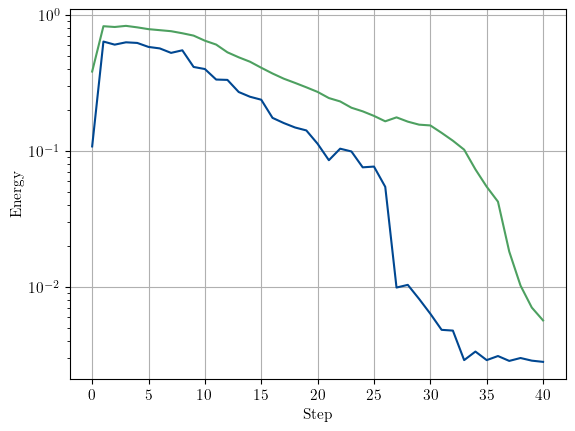

In [196]:
data_path = "../../results/portfolio/MPS_dtau10/ising_Ns10_Nt9_Nq2_K10_gamma1_zeta0.042_rho1.0_triangular_chi128_fiedler/results.h5"
gurobi_value = -9.09167

with h5py.File(data_path, "r") as data:
    samples = data["samples"][:]
    energy_samples = data["energy_samples"][:]

best_energy = energy_samples.min(axis=1)
avg_energy = energy_samples.mean(axis=1)

# Best sample at each step
best_samples = samples[np.arange(samples.shape[0]), energy_samples.argmin(axis=1)]

plt.semilogy(1-best_energy/gurobi_value, label="Best energy / Gurobi")
plt.semilogy(1-avg_energy/gurobi_value, label="Average energy / Gurobi")

plt.xlabel("Step")
plt.ylabel("Energy")
plt.grid()

In [197]:
# apply index to tnq on every sample
tnq_solutions = np.array([solution_to_tnq(sample) for sample in best_samples])

gurobi_sol = [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
tnq_gurobi = solution_to_tnq(gurobi_sol)

(41, 9)


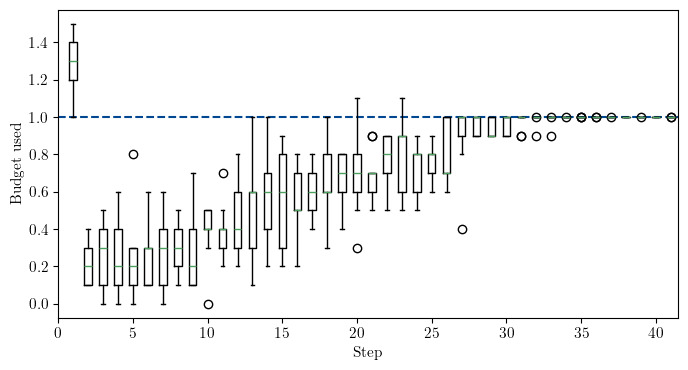

array([[[1, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 1],
        [0, 0],
        [0, 1],
        [0, 0],
        [0, 1],
        [1, 0]],

       [[0, 1],
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
        [0, 0],
        [0, 1],
        [0, 0],
        [0, 0],
        [0, 1]],

       [[0, 1],
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
        [0, 0],
        [0, 1]],

       [[0, 1],
        [0, 0],
        [0, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
        [0, 0],
        [0, 1]],

       [[0, 0],
        [0, 1],
        [1, 0],
        [0, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 0],
        [0, 1],
        [0, 0]],

       [[1, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 1],
        [0, 0],
        [1, 0]],

       [[1, 1],
        [0, 

In [198]:
decode_weights(tnq_solutions, K)

spread = decode_weights(tnq_solutions, K).sum(axis=2)

print(spread.shape)
plt.figure(figsize=(8, 4))
plt.boxplot(spread.T)

# Set custom x-axis ticks
num_steps = spread.shape[0]  # number of columns = number of boxplots
plt.xticks(
    ticks=list(range(0, num_steps + 1, 5)),
    labels=list(range(0, num_steps + 1, 5))
)

plt.axhline(y=1, color='C0', linestyle='--', label='Budget constraint', zorder=-3)
plt.ylabel("Budget used")
plt.xlabel("Step")
plt.show()


tnq_solutions[-1]

Profit [-0.04812392 -0.01800419 -0.01298398 -0.00521472  0.0058281  -0.01387895
 -0.00227712  0.00436209 -0.00943325  0.00076749  0.00124562  0.00522537
  0.00341889  0.00543479  0.00551135  0.00774904  0.01048738  0.0247124
  0.01038395  0.01585169  0.01625328  0.01541078  0.01809356  0.02149125
  0.02380247  0.02493152  0.01742137  0.04216211  0.0480999   0.04790607
  0.05438883  0.05815795  0.05870685  0.06572451  0.06168037  0.06571259
  0.06386373  0.06606683  0.064803    0.0659821   0.0665265 ]
Sharpe ratio [0.72289848 0.5353792  0.31891516 1.03844467 1.15405947 0.61302722
 2.14595895 1.97455822 1.23483117 2.12350137 2.17291564 2.25993139
 1.72564603 1.90493066 1.74058319 2.42150025 2.3445531  2.28012188
 2.3448578  2.68284555 2.54397819 2.6253267  2.44801782 2.70977098
 2.73107313 2.59384432 2.29760443 2.91452997 2.79613429 2.82094438
 2.97791439 2.98630827 3.06144097 3.17111535 2.92394233 3.22036942
 3.07700507 3.21665702 3.10369787 3.1536616  3.11107879]
Gurobi profit 0.092141

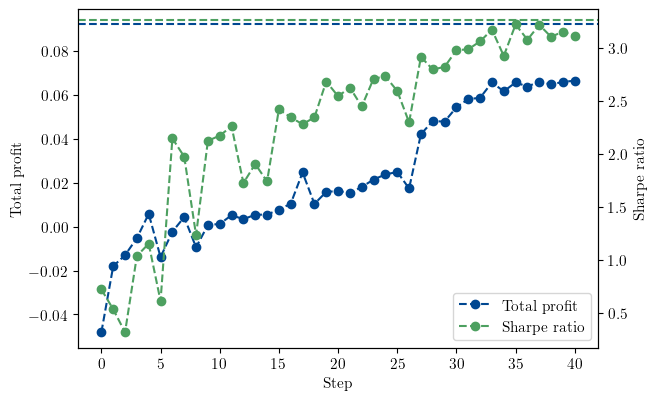

In [199]:
profit = total_profit(tnq_solutions, mu, K, 0.042)
sr = sharpe_ratio(tnq_solutions, mu, sigma, K)

print("Profit", profit)
print("Sharpe ratio", sr)

# Print sr and profit for gurobi
profit_gurobi = total_profit(tnq_gurobi[None, :, :, :], mu, K, 0.042)[0]
sr_gurobi = sharpe_ratio(tnq_gurobi[None, :, :, :], mu, sigma, K)[0]
print("Gurobi profit", profit_gurobi)
print("Gurobi Sharpe ratio", sr_gurobi)

fig, ax = plt.subplots(figsize=set_size(width=484, fraction=1, subplots=(1, 1)))

ax.plot(profit, marker='o', linestyle="--", label="Total profit")
ax.set_ylabel("Total profit")
ax.set_xlabel("Step")

ax2 = ax.twinx()
ax2.plot(sr, marker="o", linestyle="--", color='C1', label="Sharpe ratio")
ax2.set_ylabel("Sharpe ratio")
ax2.set_xlabel("Step")

ax.axhline(y=profit_gurobi, color='C0', linestyle='--')
ax2.axhline(y=sr_gurobi, color='C1', linestyle='--')

# Add custom legend on ax
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right')
plt.tight_layout()

/tmp/ipykernel_3022835/1386724021.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([8, 16, 32, 64, 128])


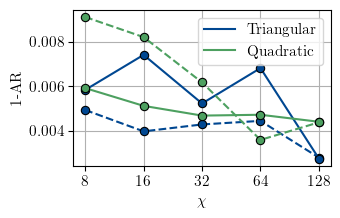

In [260]:
chi_list = [8, 16, 32, 64, 128]
gurobi_value = -9.09167
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

for row, architecture in enumerate(["triangular", "quadratic"]):
    for qubit_ordering in ["fiedler", "default"]:
        final_AR_list = np.zeros(len(chi_list))
        for i, chi in enumerate(chi_list):
            data_path = f"../../results/portfolio/MPS_dtau10/ising_Ns10_Nt9_Nq2_K10_gamma1_zeta0.042_rho1.0_{architecture}_chi{chi}_{qubit_ordering}/results.h5"
            with h5py.File(data_path, "r") as data:
                samples = data["energy_samples"][:]
                best_sample = samples.min(axis=1)
                avg_energy = samples.mean(axis=1)

            # Get the best overall sample, which would be the output
            best_sample = best_sample.min()
            #best_sample = best_sample[-1]
            final_AR = best_sample / gurobi_value
            final_AR_list[i] = final_AR

        if architecture == "quadratic":
                color = "C1"
        else:
            color = "C0"

        # Plot - / -- for fiedler, : for shuffle
        if qubit_ordering == "fiedler":
            linestyle = "--"
        else:
            linestyle = "-"

        ax.plot( 
            1-final_AR_list,
            linestyle=linestyle,
            color=color,
            markeredgecolor="black",
            marker="o",
            markersize=6,
            markeredgewidth=.8,
            label =f"{architecture}"
        )
        ax.grid(True)

ax.set_xticklabels([8, 16, 32, 64, 128])
ax.set_xticks([0, 1, 2, 3, 4])

legend_elements = [
    Line2D([0], [0], color='C0', linestyle='-', label='Triangular'),
    Line2D([0], [0], color='C1', linestyle='-', label='Quadratic')
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlabel(r"$\chi$")
ax.set_ylabel("1-AR")

fig.set_size_inches(set_size(fraction=1, subplots=(1, 1)))
fig.set_dpi(100)
fig.tight_layout(pad=.01)

# # save as pdf
# fig.savefig("paper_figures/AR_architechture_MC.pdf", bbox_inches='tight')

# Final plots

In [202]:
gurobi_sol = [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
tnq_gurobi = solution_to_tnq(gurobi_sol)
gurobi_value = -9.09167

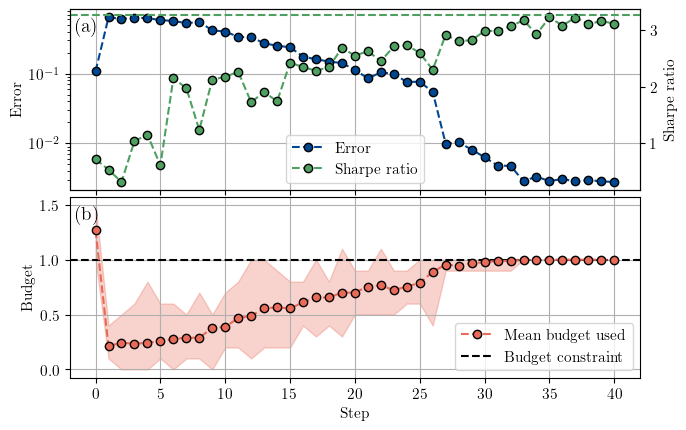

In [251]:
fig, axes = plt.subplots(2, 1, figsize=set_size(width = "full", fraction=1, subplots=(2, 1), squeeze_height=0.5), sharex=True)

# ----------------------------------------------------------------------------------
# Cost vs step
data_path = "../../results/portfolio/MPS_dtau10/ising_Ns10_Nt9_Nq2_K10_gamma1_zeta0.042_rho1.0_triangular_chi128_fiedler/results.h5"

with h5py.File(data_path, "r") as data:
    samples = data["samples"][:]
    energy_samples = data["energy_samples"][:]
    
best_samples = samples[np.arange(samples.shape[0]), energy_samples.argmin(axis=1)]
tnq_solutions = np.array([solution_to_tnq(sample) for sample in best_samples])

best_energy = energy_samples.min(axis=1)
avg_energy = energy_samples.mean(axis=1)

axes[0].semilogy(1-best_energy/gurobi_value, label="Error", marker = 'o', linestyle="--", markeredgecolor="black")
#axes[0].semilogy(1-avg_energy/gurobi_value, label="Average energy / Gurobi")

#axes[0].set_xlabel("Step")
axes[0].set_ylabel("Error")
axes[0].grid()
axes[0].text(
    0.01, .85, "(a)",
    transform=axes[0].transAxes,
    va="bottom", ha="left", fontsize=14, fontweight="bold"
)

ax2 = axes[0].twinx()

# Profit and Sharpe ratio vs step
sr = sharpe_ratio(tnq_solutions, mu, sigma, K)
sr_gurobi = sharpe_ratio(tnq_gurobi[None, :, :, :], mu, sigma, K)[0]
#profit = total_profit(tnq_solutions, mu, K, 0.042)
#profit_gurobi = total_profit(tnq_gurobi[None, :, :, :], mu, K, 0.042)[0]

ax2.plot(sr, marker='o', linestyle="--", label="Sharpe ratio", color = "C1", markeredgecolor="black",)
ax2.set_ylabel("Sharpe ratio")
ax2.set_xlabel("Step")

ax2.axhline(y=sr_gurobi, color='C1', linestyle='--')

# Add custom legend on ax
lines, labels = axes[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[0].legend(lines + lines2, labels + labels2, loc='lower center')

# Adhering to constraint
# ----------------------------------------------------------------------------------
min_budget = decode_weights(tnq_solutions, K).sum(axis=2).min(axis=1)
max_budget = decode_weights(tnq_solutions, K).sum(axis=2).max(axis=1)
mean_budget = decode_weights(tnq_solutions, K).sum(axis=2).mean(axis=1)

axes[1].plot(mean_budget, label='Mean budget used', color='C2', zorder=3, marker='o', linestyle='--', markeredgecolor="black")

axes[1].fill_between(
    x=np.arange(len(min_budget)),
    y1=min_budget,
    y2=max_budget,
    color='C2',
    alpha=0.3
)

# spread = decode_weights(tnq_solutions, K).sum(axis=2)
# axes[1].boxplot(spread.T)

# Set custom x-axis ticks
num_steps = spread.shape[0]  # number of columns = number of boxplots
axes[1].set_xticks(
    ticks=list(range(0, num_steps + 1, 5)),
    labels=list(range(0, num_steps + 1, 5))
)

axes[1].axhline(y=1, color='black', linestyle='--', label='Budget constraint')
axes[1].set_ylabel("Budget")
axes[1].set_xlabel("Step")
axes[1].legend(loc='lower right')
axes[1].grid()

axes[1].text(
    0.01, .85, "(b)",
    transform=axes[1].transAxes,
    va="bottom", ha="left", fontsize=14, fontweight="bold"
)

fig.tight_layout(pad=0.1)

# save figure
fig.savefig("../../figures/figures_mpl/paper_figures/portfolio_optimization_results.pdf", dpi=300)